# Maximum Flow Problem

* Example from textbook
* Use `networkx` to plot the figures

In [7]:
import networkx as nx

G = nx.DiGraph()

nodes = ['O', 'A', 'B', 'C', 'D', 'E', 'T']
G.add_nodes_from(nodes)

In [8]:
edges = [('O', 'A', 5), ('O', 'B', 7), ('O', 'C', 4),
         ('A', 'B', 1), ('A', 'D', 3), 
         ('B', 'C', 2), ('B', 'D', 4), ('B', 'E', 5),
         ('C', 'E', 4), 
         ('D', 'T', 9), 
         ('E', 'D', 1), ('E', 'T', 6)]
G.add_weighted_edges_from(edges)
G.edges(data=True)

OutEdgeDataView([('O', 'A', {'weight': 5}), ('O', 'B', {'weight': 7}), ('O', 'C', {'weight': 4}), ('A', 'B', {'weight': 1}), ('A', 'D', {'weight': 3}), ('B', 'C', {'weight': 2}), ('B', 'D', {'weight': 4}), ('B', 'E', {'weight': 5}), ('C', 'E', {'weight': 4}), ('D', 'T', {'weight': 9}), ('E', 'D', {'weight': 1}), ('E', 'T', {'weight': 6})])

#### Set the position of each node in the graph 
The position can be defined by yourself.

In [9]:
pos = {
    'O': (0, 0),
    'A': (1, 1),
    'B': (1, 0),
    'C': (1, -1),
    'D': (2, 0.5),
    'E': (2, -0.5),
    'T': (3, 0)
}

#### Show the original network

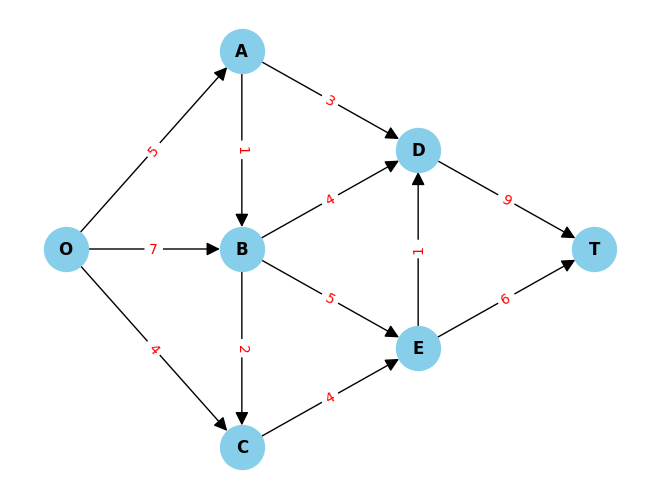

In [10]:
import matplotlib.pyplot as plt

nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
edge_labels = {(u, v): w['weight'] for u, v, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.show()

#### Connect the starting point and the endpoint

In [5]:
G.add_edge('T', 'O', capacity=float('inf'))

#### Optimize by Gurobi

In [6]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
model = gp.Model('maximum_flow')

# Create decision variables
x = model.addVars(nodes, nodes, vtype=GRB.INTEGER, name='x')

# Set objective function
model.setObjective(x['T', 'O'], GRB.MAXIMIZE)

# Add constraints
model.addConstr(x['T', 'O'] == x['O', 'A'] + x['O', 'B'] + x['O', 'C'], 'c1') # o
model.addConstr(x['O', 'A'] == x['A', 'B'] + x['A', 'D'], 'c2') # a
model.addConstr(x['O', 'B'] == x['B', 'C'] + x['B', 'D'] + x['B', 'E'], 'c3') # b
model.addConstr(x['O', 'C'] + x['B', 'C'] == x['C', 'E'], 'c4') # c
model.addConstr(x['A', 'D'] + x['B', 'D'] + x['E', 'D'] == x['D', 'T'], 'c5') # d
model.addConstr(x['B', 'E'] + x['C', 'E'] == x['E', 'D'] + x['E', 'T'], 'c6') # e
model.addConstr(x['D', 'T'] + x['E', 'T'] == x['T', 'O'], 'c7') # t

for i, (u, v, w) in enumerate(edges):
    model.addConstr(x[u, v] <= w, 'c8_%d' % i)


# Update the model
model.update()

# Optimize the model
model.optimize()

# Create .lp file
model.write('maximum_flow.lp')

# Print the solution
if model.status == GRB.OPTIMAL:
    print('Number of variables: ', model.numVars)
    print('Number of constraints: ', model.numConstrs)
    print('Objective value: ', model.objVal)
    #for v in model.getVars():
        #print('%s = %d' % (v.varName, v.x))
else:
    print('No solution found.')

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



Optimize a model with 19 rows, 49 columns and 37 nonzeros
Model fingerprint: 0x5a41c63b
Variable types: 0 continuous, 49 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 15 rows and 42 columns
Presolve time: 0.00s
Presolved: 4 rows, 7 columns, 14 nonzeros
Found heuristic solution: objective 4.0000000
Variable types: 0 continuous, 7 integer (0 binary)
Found heuristic solution: objective 5.0000000

Root relaxation: objective 1.400000e+01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      14.0000000   14.00000  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 8

#### Obtain the flow on each edge

In [11]:
# Update the flow values in the edges list
for i, (u, v, _) in enumerate(edges):
    edges[i] = (u, v, int(x[u, v].x))

print(edges)

[('O', 'A', 3), ('O', 'B', 7), ('O', 'C', 4), ('A', 'B', 0), ('A', 'D', 3), ('B', 'C', 0), ('B', 'D', 4), ('B', 'E', 3), ('C', 'E', 4), ('D', 'T', 8), ('E', 'D', 1), ('E', 'T', 6)]


#### Show the final result

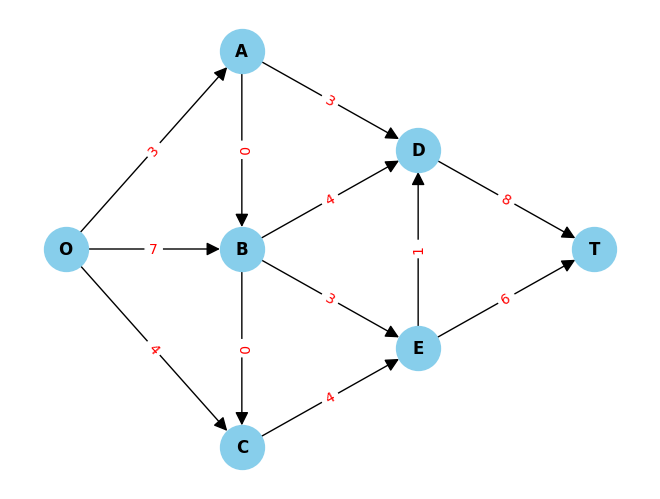

In [12]:
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
edge_labels = {(u, v): w for u, v, w in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.show()